In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
#matplotlib.use("TkAgg")
from utils import preprocess, feature_engg
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import mean_squared_error, r2_score
import random, os
from transformers import *
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline

from sklearn.preprocessing import StandardScaler
import itertools

from sklearn.linear_model import (
    ElasticNetCV, LassoCV, RidgeCV, LinearRegression, Lasso, SGDRegressor
)
from sklearn.svm import LinearSVR
from sklearn.ensemble import (RandomForestRegressor, StackingRegressor)
from xgboost import XGBRegressor
from scipy.stats import skew
from lightgbm import LGBMRegressor

import pickle

In [2]:
def plot_dist_vs_fare(X_train, y_train):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.scatter(X_train['hdist_mi'], y_train)
    ax.set_xlabel('Haversine Dist (in miles)')
    ax.set_ylabel('Fare amount in USD')
    plt.show()

In [3]:
from sklearn.impute import KNNImputer
def process_dist_outliers(trans_df, dist=0):
    mask = trans_df['hdist_mi'] <= dist
    miss_dist_indices = trans_df.loc[mask].index
    
    for i in miss_dist_indices:
        trans_df.loc[i, 'hdist_mi'] = 9999
        
        #knn_imp = KNNImputer(missing_values=9999, n_neighbors=3)
        
    if len(miss_dist_indices) > 0:
        knn_imp = KNNImputer(missing_values=9999, n_neighbors=3)
        
        ktrans_df = knn_imp.fit_transform(trans_df)
        kdf = pd.DataFrame(ktrans_df, index=trans_df.index, columns=trans_df.columns)
        print('Imputed : {} hdist_mi using KNN Imputer...'.format(len(miss_dist_indices)))
        '''
        for i in miss_dist_indices:
            print(kdf.loc[i, 'hdist_mi'])
        '''
        return kdf 
    print('No need to run KNN Imputer for distance')
    return trans_df

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
def flatten(list2d):
    merged = list(itertools.chain.from_iterable(list2d))
    return merged  

def get_RMSE(pipeline, X, y, folds):

    MSE_scores = -1 * cross_val_score(pipeline, X, y, cv=folds, scoring='neg_mean_squared_error')
    RMSE_scores = np.sqrt(MSE_scores)
    
    return RMSE_scores    

def get_cross_val_scores_with_model_stacking(X_train, y_train):
    models = [
    LassoCV(),
    RandomForestRegressor(),
    XGBRegressor(), 
    LGBMRegressor()   
]  
    #  Define estimators to stacked regressor

    estimator_names = ['lassoCV', 'random_forest', 'xgbregressor', 'lgbmregressor']
    estimators = [(estimator_names[i], model) for i, model in enumerate(models)]

    #  Define stacked model with Linear Regression as the final estimator
    Stacked = StackingRegressor(estimators=estimators, final_estimator=LassoCV(), cv=5)
    
    #  Add stacked model to models list from previous step
    models.append(Stacked)
    
    print('RMSE Cross-Validation Training Scores With Stacked Model \n')
    
    RMSE = []
    model_names = []
    mean_RMSE = []
    for i, model in enumerate(models):
        
        #  Fit training data and score
        RMSE.append(get_RMSE(model, X_train, y_train, 5))
        
        model_names.append(str(model).split('(')[0])
        mean_rmse = round(np.mean(RMSE[i]), 2)
        mean_RMSE.append(mean_rmse)
        print('{} Training Score: {}'.format(model_names[i], mean_rmse))
    return RMSE, mean_RMSE, model_names, models

def process_data(rows=500, impute_dist=0):
    try:
        print("Reading in the dataset. This will take some time..")
        df = pd.read_csv('NYC_taxi.csv', 
                         parse_dates=['pickup_datetime'], 
                         nrows=rows)
    except:
        print("Dataset not found")
        quit()
    
    seed_everything()
    # Perform preprocessing and feature engineering
    df = preprocess(df)
    preprocessed_df = df.copy()
    
    y = df['fare_amount']
    df = df.drop(['key'], axis=1)
    X = df.drop(columns=['fare_amount'])
    
    scaled_df = feature_engg(X, impute_dist)
    print(scaled_df.head(2))
    
    X_train, X_test, y_train, y_test =\
        train_test_split(scaled_df, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test
   

In [5]:
def cross_validate_models():   
    RMSE, mean_RMSE, model_names, models = get_cross_val_scores_with_model_stacking(X_train, y_train)  
    return RMSE, mean_RMSE, model_names, models

In [38]:
X_train, X_test, y_train, y_test = process_data(10000, 0)

Reading in the dataset. This will take some time..
categorical cols: Index(['pickup_datetime'], dtype='object')
numeric cols: Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')
Done with categorical transform
               pickup_datetime  year  month  day  day_of_week  hour  \
0    2009-06-15 17:26:21+00:00  2009      6   15            0    17   
1    2010-01-05 16:52:16+00:00  2010      1    5            1    16   
2    2011-08-18 00:35:00+00:00  2011      8   18            3     0   
3    2012-04-21 04:30:42+00:00  2012      4   21            5     4   
4    2010-03-09 07:51:00+00:00  2010      3    9            1     7   
...                        ...   ...    ...  ...          ...   ...   
9995 2011-10-26 10:44:00+00:00  2011     10   26            2    10   
9996 2011-12-16 15:37:00+00:00  2011     12   16            4    15   
9997 2013-11-16 22:47:17+00:00  2013     11   16            5    22

/home/padmac/kaggle/nyc_fare/transformers.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df[self.variable].dt.year
/home/padmac/kaggle/nyc_fare/transformers.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df[self.variable].dt.month
/home/padmac/kaggle/nyc_fare/transformers.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Done with numeric transform
      pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0           -73.844311        40.721319         -73.841610         40.712278   
1           -74.016048        40.711303         -73.979268         40.782004   
2           -73.982738        40.761270         -73.991242         40.750562   
3           -73.987130        40.733143         -73.991567         40.758092   
4           -73.968095        40.768008         -73.956655         40.783762   
...                ...              ...                ...               ...   
9995        -73.988277        40.748970         -73.963712         40.773958   
9996        -74.002112        40.748727         -73.992467         40.756252   
9997        -73.992093        40.729071         -73.974470         40.763050   
9998        -73.992548        40.735652         -73.998802         40.723085   
9999        -73.978400        40.751700         -74.010500         40.713600   

      passe

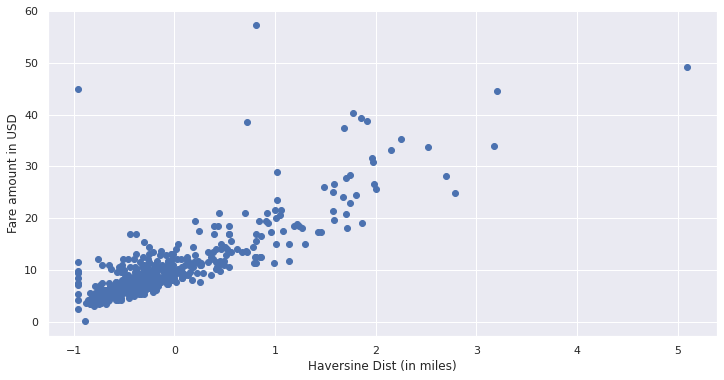

In [39]:
plot_dist_vs_fare(X_train[:500], y_train[:500])

In [40]:
X_train.shape

(7719, 19)

In [41]:
X_train.columns

Index(['year', 'month', 'day', 'day_of_week', 'hour', 'is_weekend',
       'is_after_hrs', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hdist_mi',
       'pickup_dist_from_jfk', 'dropoff_dist_from_jfk', 'pickup_dist_from_lag',
       'dropoff_dist_from_lag', 'pickup_dist_from_new',
       'dropoff_dist_from_new'],
      dtype='object')

In [42]:
RMSE, mean_RMSE, model_names, models  = cross_validate_models()

RMSE Cross-Validation Training Scores With Stacked Model 

LassoCV Training Score: 3.78
RandomForestRegressor Training Score: 3.63
[13:26:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor Training Score: 3.55
LGBMRegressor Training Score: 3.55
[13:26:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:sq

/home/padmac/anaconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.626521118945675, tolerance: 28.347954522770756
  tol, rng, random, positive)
/home/padmac/anaconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.87509866282926, tolerance: 27.698830456718117
  tol, rng, random, positive)
/home/padmac/anaconda3/envs/ml_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.249305380813894, tolerance: 27.698830456718117
  tol, rng, random, positive)


[13:27:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:28:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:28:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:28:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [43]:
RMSE

[array([3.39238727, 3.82802755, 4.24271431, 3.69654393, 3.73954419]),
 array([3.30102453, 3.73223193, 4.00536476, 3.51286858, 3.58383855]),
 array([3.22331872, 3.59894077, 3.9861246 , 3.4367341 , 3.49446521]),
 array([3.33014915, 3.69425964, 3.81497326, 3.4354304 , 3.46747839]),
 array([3.19685814, 3.57540802, 3.84640355, 3.36569171, 3.4155023 ])]

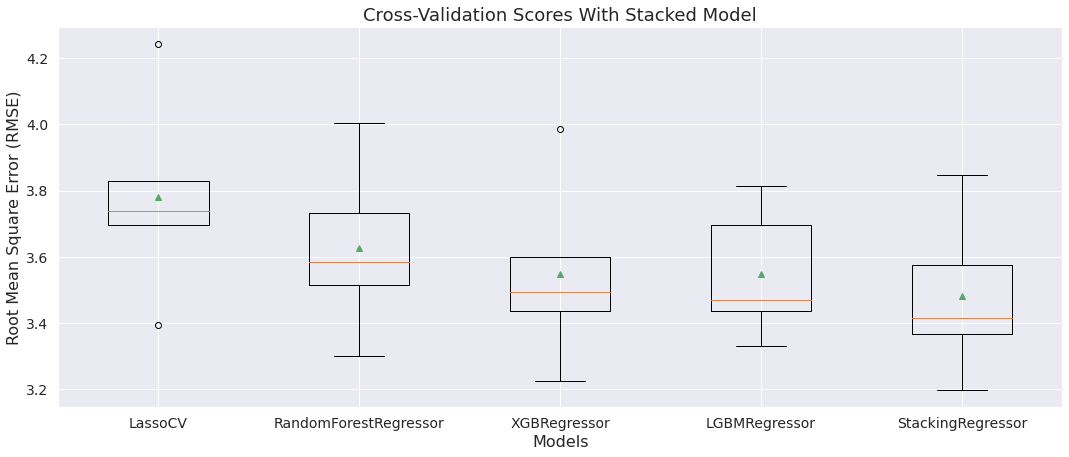

In [44]:
#  Create a boxplot of the scores
plt.figure(figsize=(18,7))
plt.boxplot(RMSE, labels=model_names, showmeans=True)
plt.xlabel('Models', fontsize=16)
plt.ylabel('Root Mean Square Error (RMSE)', fontsize=16)
plt.title('Cross-Validation Scores With Stacked Model', fontsize=18)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.tick_params(axis = 'both', which = 'minor', labelsize = 14)

In [45]:
mean_RMSE

[3.78, 3.63, 3.55, 3.55, 3.48]

In [46]:
tmp = list(zip(mean_RMSE, model_names))
sorted_rmses = sorted(tmp, key=lambda rec: rec[0])
print('Sorted RMSE/model:\n {}'.format(sorted_rmses))

Sorted RMSE/model:
 [(3.48, 'StackingRegressor'), (3.55, 'XGBRegressor'), (3.55, 'LGBMRegressor'), (3.63, 'RandomForestRegressor'), (3.78, 'LassoCV')]


In [47]:
best_model_idx = np.argmin(mean_RMSE)
print(' best model : {} rmse: {}'.format(model_names[best_model_idx], mean_RMSE[best_model_idx]))

 best model : StackingRegressor rmse: 3.48


In [48]:
best_model = models[best_model_idx]
X_train, X_test, y_train, y_test = process_data(70000, impute_dist=0)
best_model.fit(X_train, y_train)

Reading in the dataset. This will take some time..
categorical cols: Index(['pickup_datetime'], dtype='object')
numeric cols: Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')


/home/padmac/kaggle/nyc_fare/transformers.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df[self.variable].dt.year
/home/padmac/kaggle/nyc_fare/transformers.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df[self.variable].dt.month
/home/padmac/kaggle/nyc_fare/transformers.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Done with categorical transform
                pickup_datetime  year  month  day  day_of_week  hour  \
0     2009-06-15 17:26:21+00:00  2009      6   15            0    17   
1     2010-01-05 16:52:16+00:00  2010      1    5            1    16   
2     2011-08-18 00:35:00+00:00  2011      8   18            3     0   
3     2012-04-21 04:30:42+00:00  2012      4   21            5     4   
4     2010-03-09 07:51:00+00:00  2010      3    9            1     7   
...                         ...   ...    ...  ...          ...   ...   
69995 2013-08-25 19:41:00+00:00  2013      8   25            6    19   
69996 2013-02-14 17:31:01+00:00  2013      2   14            3    17   
69997 2011-03-05 22:31:02+00:00  2011      3    5            5    22   
69998 2011-06-30 16:41:00+00:00  2011      6   30            3    16   
69999 2011-10-06 07:06:09+00:00  2011     10    6            3     7   

       is_weekend  is_after_hrs  
0               0             0  
1               0             0  
2

StackingRegressor(cv=5,
                  estimators=[('lassoCV', LassoCV()),
                              ('random_forest', RandomForestRegressor()),
                              ('xgbregressor', XGBRegressor()),
                              ('lgbmregressor', LGBMRegressor())],
                  final_estimator=LassoCV())

In [49]:
# save model to disk
fname = 'nyc_stacked_model.sav'
pickle.dump(best_model, open(fname, 'wb'))

In [50]:
def feature_engineer_test_data(X, impute_dist=0):
    cat_pipe = pickle.load(open('catpipe.sav', 'rb'))
    num_pipe = pickle.load(open('numpipe.sav', 'rb'))
    scaler = pickle.load(open('scaler.sav', 'rb'))
    
    #categorical_columns = pd.Index(['pickup_datetime']) 
    #numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
    
    ctrans_df = cat_pipe.transform(X)
    print('Done with categorical transform')
    print('=====ctrans_df=======')
    print(ctrans_df)

    ctrans_df.drop(columns=['pickup_datetime'], inplace=True)

    ntrans_df = num_pipe.transform(X)
    print('Done with numeric transform')
    print('=====ntrans_df=======')

    print(ntrans_df)

    combined_df = pd.concat([ctrans_df, ntrans_df], axis=1)
    print('=====combined_df=======')

    print('combined_df shape: {}'.format(combined_df.shape))
    print(combined_df.info())
        
    trans_df = combined_df
    print('=====trans_df=======')

    print(trans_df)

    scaled_data = scaler.transform(trans_df)
    scaled_df = pd.DataFrame(scaled_data, columns=trans_df.columns, index=trans_df.index)

    print('Done with scaling')
    #print(scaled_df)

    return scaled_df    

In [51]:
def predict_for_test_data(model, test_df=None):
    if test_df is None:
        test_df = pd.read_csv('test.csv', parse_dates=['pickup_datetime'])

        mtest_df = test_df.drop(['key'], axis=1)
        scaled_test_df= feature_engineer_test_data(mtest_df, impute_dist=0)
    
    else:
        scaled_test_df = feature_engineer_test_data(test_df)
         
    y_pred_orig = model.predict(scaled_test_df)
    
    return y_pred_orig, scaled_test_df

In [52]:
test_df = pd.read_csv('test.csv', parse_dates=['pickup_datetime'])
mtest_df = test_df.drop(['key'], axis=1)

In [53]:
mtest_df.shape

(9914, 6)

In [54]:
scaled_test_df= feature_engineer_test_data(mtest_df, impute_dist=0)

/home/padmac/kaggle/nyc_fare/transformers.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df[self.variable].dt.year
/home/padmac/kaggle/nyc_fare/transformers.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df[self.variable].dt.month
/home/padmac/kaggle/nyc_fare/transformers.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Done with categorical transform
=====ctrans_df=======
               pickup_datetime  year  month  day  day_of_week  hour  \
0    2015-01-27 13:08:24+00:00  2015      1   27            1    13   
1    2015-01-27 13:08:24+00:00  2015      1   27            1    13   
2    2011-10-08 11:53:44+00:00  2011     10    8            5    11   
3    2012-12-01 21:12:12+00:00  2012     12    1            5    21   
4    2012-12-01 21:12:12+00:00  2012     12    1            5    21   
...                        ...   ...    ...  ...          ...   ...   
9909 2015-05-10 12:37:51+00:00  2015      5   10            6    12   
9910 2015-01-12 17:05:51+00:00  2015      1   12            0    17   
9911 2015-04-19 20:44:15+00:00  2015      4   19            6    20   
9912 2015-01-31 01:05:19+00:00  2015      1   31            5     1   
9913 2015-01-18 14:06:23+00:00  2015      1   18            6    14   

      is_weekend  is_after_hrs  
0              0             0  
1              0           

In [55]:
scaled_test_df.shape

(9914, 19)

In [56]:
scaled_test_df.columns

Index(['year', 'month', 'day', 'day_of_week', 'hour', 'is_weekend',
       'is_after_hrs', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hdist_mi',
       'pickup_dist_from_jfk', 'dropoff_dist_from_jfk', 'pickup_dist_from_lag',
       'dropoff_dist_from_lag', 'pickup_dist_from_new',
       'dropoff_dist_from_new'],
      dtype='object')

In [57]:
# load model from disk
loaded_model = pickle.load(open(fname, 'rb'))

[13:35:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [58]:
y_pred, scaled_test_df = predict_for_test_data(best_model)

/home/padmac/kaggle/nyc_fare/transformers.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df[self.variable].dt.year
/home/padmac/kaggle/nyc_fare/transformers.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df[self.variable].dt.month
/home/padmac/kaggle/nyc_fare/transformers.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Done with categorical transform
=====ctrans_df=======
               pickup_datetime  year  month  day  day_of_week  hour  \
0    2015-01-27 13:08:24+00:00  2015      1   27            1    13   
1    2015-01-27 13:08:24+00:00  2015      1   27            1    13   
2    2011-10-08 11:53:44+00:00  2011     10    8            5    11   
3    2012-12-01 21:12:12+00:00  2012     12    1            5    21   
4    2012-12-01 21:12:12+00:00  2012     12    1            5    21   
...                        ...   ...    ...  ...          ...   ...   
9909 2015-05-10 12:37:51+00:00  2015      5   10            6    12   
9910 2015-01-12 17:05:51+00:00  2015      1   12            0    17   
9911 2015-04-19 20:44:15+00:00  2015      4   19            6    20   
9912 2015-01-31 01:05:19+00:00  2015      1   31            5     1   
9913 2015-01-18 14:06:23+00:00  2015      1   18            6    14   

      is_weekend  is_after_hrs  
0              0             0  
1              0           

In [59]:
y_pred.shape, scaled_test_df.shape

((9914,), (9914, 19))

In [60]:
def create_submission_file(y_pred):
    #y_pred = predict_for_test_data()
    sample_submission = pd.read_csv('./sample_submission.csv')
    output = pd.DataFrame({"key": sample_submission.key, "fare_amount":y_pred})
    output.to_csv('submission.csv', index=False)
    output.head()

In [61]:
create_submission_file(y_pred)